In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
input_file = 'sx-stackoverflow.txt'
output_file = 'stackoverflow_Graphs.csv'
chunksize = 50000
delimiter = ' '
headers = ['Source_Node','Target_Node','Timestamp']

#As we are creating the output file, we put the headers and move to the next row
with open(output_file, 'w') as file:
    file.write(','.join(headers) + '\n')


In [3]:
for chunk in pd.read_csv(input_file,delimiter=delimiter,chunksize=chunksize,header=None):
    chunk.to_csv(output_file,mode = 'a',index = False,header = False)

In [4]:
df = pd.read_csv(output_file)

In [5]:
df

,Source_Node,Target_Node,Timestamp
0,9,8,1217567877
1,1,1,1217573801
2,13,1,1217606247
3,17,1,1217617639
4,48,2,1217618182
...,...,...,...
63497045,4049257,3816212,1457273371
63497046,3507137,1801524,1457273391
63497047,144088,275047,1457273420
63497048,5617035,4368648,1457273425


In [6]:
df.Timestamp.is_monotonic_increasing

False

In [7]:
df.sort_values(by= 'Timestamp',inplace= True)
df.Timestamp.is_monotonic_increasing

True

In [8]:
T = [df.Timestamp.iloc[0],df.Timestamp.iloc[-1]]

print(f'The span of the Time is T = {T}')

The span of the Time is T = [1217567877, 1457273428]


In [9]:
N = int(2774/30) #We will try to create a daily period as long as we know that in this dataset the time span is about 2774 days.

In [10]:
dt = (T[1] - T[0])/ N
dt # this is the timestamp difference, equal to about 1 day

2605495.1195652173

Now we will create the timestamps that every period is splited to:

In [11]:
tj = [T[0] + j*dt for j in range(N+1)]

In [12]:
len(tj)

93

And create the periods themselves too, as a list of tuples(start,end):

In [13]:
time_periods = [(tj[i], tj[i+1]) for i in range(N)] #We now have N periods and not N+1

In [14]:
#Let's plot the first 10 periods
time_periods[:10]

[(1217567877.0, 1220173372.1195652),
 (1220173372.1195652, 1222778867.2391305),
 (1222778867.2391305, 1225384362.3586957),
 (1225384362.3586957, 1227989857.4782608),
 (1227989857.4782608, 1230595352.597826),
 (1230595352.597826, 1233200847.7173913),
 (1233200847.7173913, 1235806342.8369565),
 (1235806342.8369565, 1238411837.9565217),
 (1238411837.9565217, 1241017333.076087),
 (1241017333.076087, 1243622828.1956522)]

Let's now create the subgraphs for every period.

In [15]:
import networkx as nx

Firstly, we create a function that returns a graph, given a specific dataframe

In [16]:
def create_subgraph(subdf):
    subgraph = nx.from_pandas_edgelist(subdf, 'Source_Node', 'Target_Node')
    return subgraph

And use a genarator to generate subgraphs instead of keeping evereything on memory. This way we can quickly use some specific graphs for specific tasks

In [17]:
def subgraphs_generator(df, time_periods):
    for start, end in time_periods[:-1]:
        subdf = df[(df.Timestamp >= start) & (df.Timestamp < end)]
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        yield subgraph

    start, end = time_periods[-1]
    subdf = df[(df.Timestamp >= start) & (df.Timestamp <= end)]
    subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
    subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
    subgraph = create_subgraph(subdf)
    yield subgraph


And create a function that calls the specific i-th subgraph:

In [18]:
def ith_subgraph(df, time_periods, index):
    if index < len(time_periods) - 1:
        start, end = time_periods[index]
        subdf = df[(df.Timestamp >= start) & (df.Timestamp < end)]
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        return subgraph
    else:
        start, end = time_periods[-1]
        subdf = df[(df.Timestamp >= start) & (df.Timestamp <= end)]
        subdf = subdf.drop_duplicates(subset=['Source_Node', 'Target_Node'])
        subdf = subdf[subdf['Source_Node'] != subdf['Target_Node']]
        subgraph = create_subgraph(subdf)
        return subgraph

Let's check the first 3 graphs and the last 3 graphs of the dataset:

In [19]:
print('The first 3 Graphs: ')
for i in range(3):
    print(ith_subgraph(df,time_periods,i))
print('The last 3 Graphs: ')
for i in range(-3,0):
    print(ith_subgraph(df,time_periods,i))


The first 3 Graphs: 
Graph with 2124 nodes and 13124 edges


Graph with 9355 nodes and 62257 edges
Graph with 9660 nodes and 61843 edges
The last 3 Graphs: 
Graph with 217087 nodes and 448032 edges
Graph with 252197 nodes and 530161 edges
Graph with 262962 nodes and 560860 edges


It is easy to see that in the first month of this dataset, Stack OverFlow had only 2,124 users with 13,124 connections , and on the last month it managed to have 262,962 users and 560,860 connections. Let's now keep the node and edges counts of every subgraph to 2 lists:

In [24]:
node_counts = []
edge_counts = []

for graph in subgraphs_generator(df,time_periods):
    node_counts.append(graph.number_of_nodes())
    edge_counts.append(graph.number_of_edges())

And try to plot the first 5 Monthly Subgraphs of the StackOverflow Network:

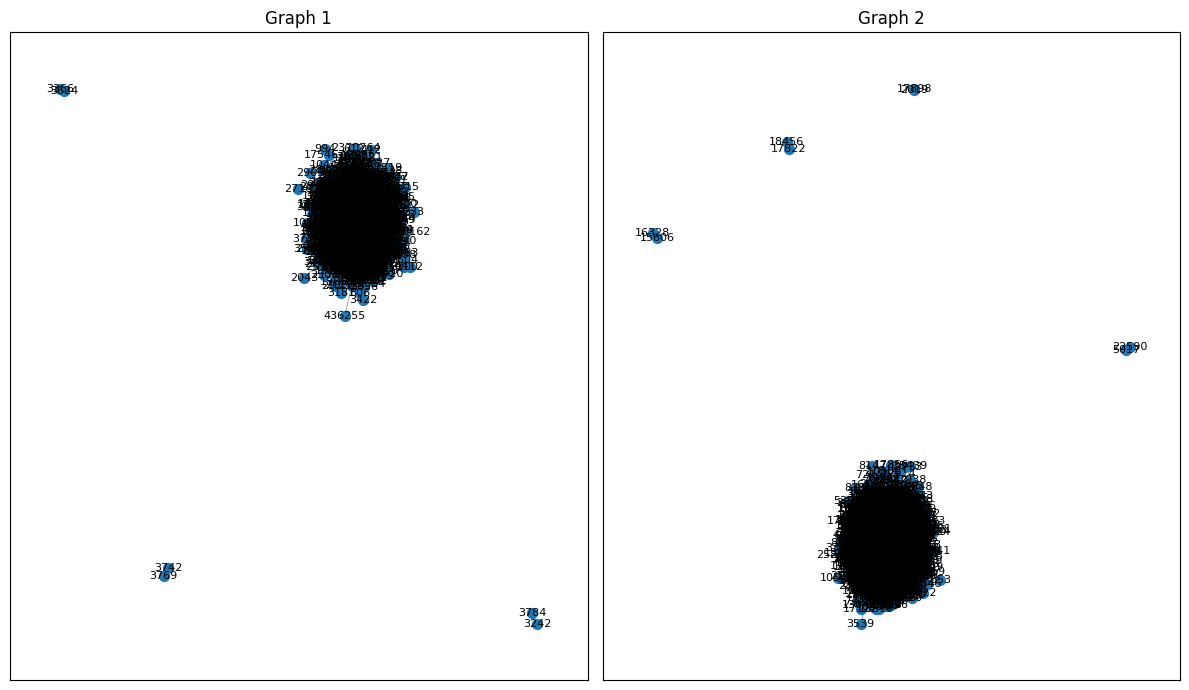

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i in range(2):
    G = ith_subgraph(df, time_periods, i)
    pos = nx.spring_layout(G)

    ax = axes[i]
    ax.set_title(f"Graph {i + 1}")

    nx.draw_networkx_nodes(G, pos, node_size=50, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

plt.tight_layout()
plt.show()

By just watching the Graphs, it seem that there is no difference in the structure between the first 2 graphs.

Let's visualize how nodes and edges counts differ through time:

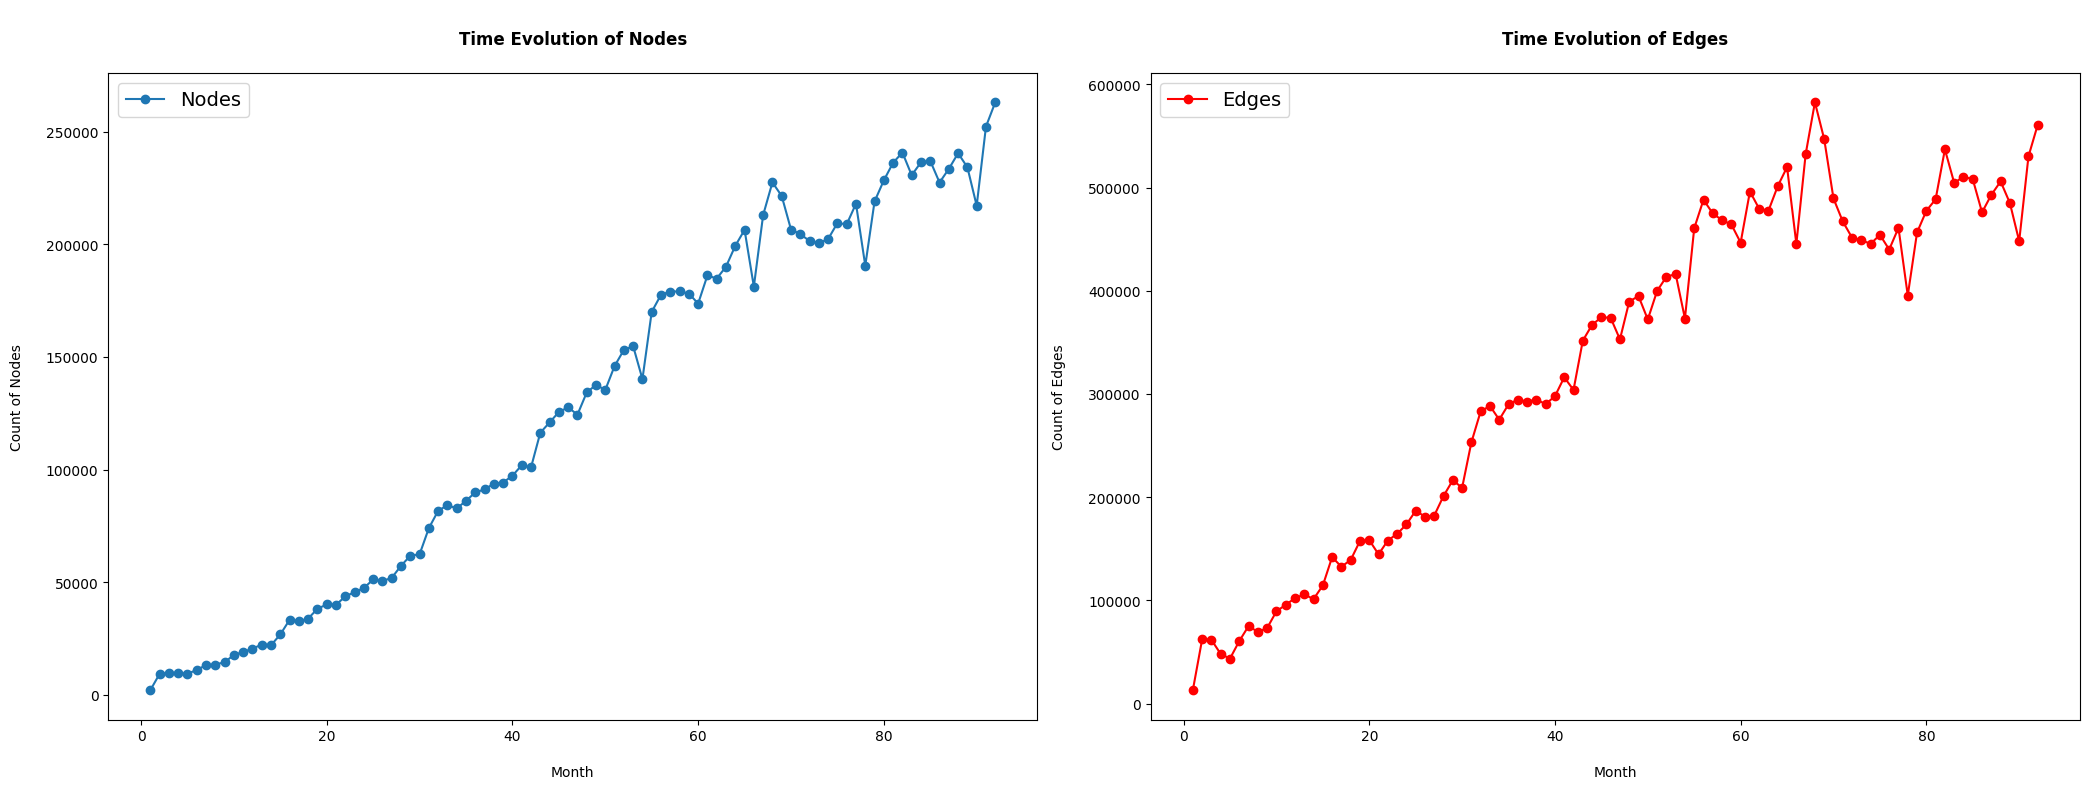

In [26]:
plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot([i + 1 for i in range(len(time_periods))], node_counts, marker='o', label='Nodes',)
plt.xlabel('\nMonth')
plt.ylabel('Count of Nodes\n')
plt.title('\nTime Evolution of Nodes\n', fontweight='bold')
plt.legend(loc='upper left', fontsize=14)

plt.subplot(1, 2, 2)
plt.plot([i + 1 for i in range(len(time_periods))], edge_counts, marker='o', label='Edges', color='red')
plt.xlabel('\nMonth')
plt.ylabel('Count of Edges\n')
plt.title('\nTime Evolution of Edges\n', fontweight='bold')
plt.legend(loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()

**It is clear that as time passes, more and more users come into the website and more and more connections are created.** It seems that periodically we have big drops of nodes and edges, but generally there is an uptrend.

# Centrality Measures

**Degree Centrality**:

- Degree centrality is the simplest centrality measure.
- It counts the number of edges connected to a node (its degree).
- Nodes with higher degrees are considered more central in terms of connections.

**Closeness Centrality**:

- Closeness centrality measures how close a node is to all other nodes in the network.
- It calculates the average shortest path length from a node to all other nodes.
- Nodes with higher closeness centrality are more reachable and central.

**Betweenness Centrality**:

- Betweenness centrality quantifies the extent to which a node lies on shortest paths between other nodes.
- It identifies nodes that act as bridges, connecting different parts of the network.
- Nodes with high betweenness centrality often have control over information flow.

**Eigenvector Centrality**:

- Eigenvector centrality takes into account the centrality of a node's neighbors.
- It assigns higher scores to nodes connected to other high-scoring nodes.
- It reflects the idea that being connected to influential nodes makes a node more influential itself.

**Katz Centrality**:

- Katz centrality is similar to eigenvector centrality but allows for a parameterized influence from neighbors.
- It considers both direct and indirect connections.
- Nodes with higher Katz centrality are those that have influential neighbors.

We will now create a function that will retun the centrality measures for a given graph:

In [20]:
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    katz_centrality = nx.katz_centrality(G, alpha=0.01, beta=0.1, max_iter=5000)



    return degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality, katz_centrality

In [28]:
degree_centrality1, closeness_centrality1, betweenness_centrality1, eigenvector_centrality1, katz_centrality1 = compute_centrality_measures(ith_subgraph(df,time_periods,5))

In [29]:

degree_centrality2, closeness_centrality2, betweenness_centrality2, eigenvector_centrality2, katz_centrality2 = compute_centrality_measures(ith_subgraph(df,time_periods,6))

In [30]:
import seaborn as sns

In [31]:
centrality_measures1 = [ degree_centrality1, closeness_centrality1, betweenness_centrality1, eigenvector_centrality1, katz_centrality1]
centrality_measures2 = [ degree_centrality2, closeness_centrality2, betweenness_centrality2, eigenvector_centrality2, katz_centrality2]
                       
                       
titles = ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "Eigenvector Centrality", "Katz Centrality"]

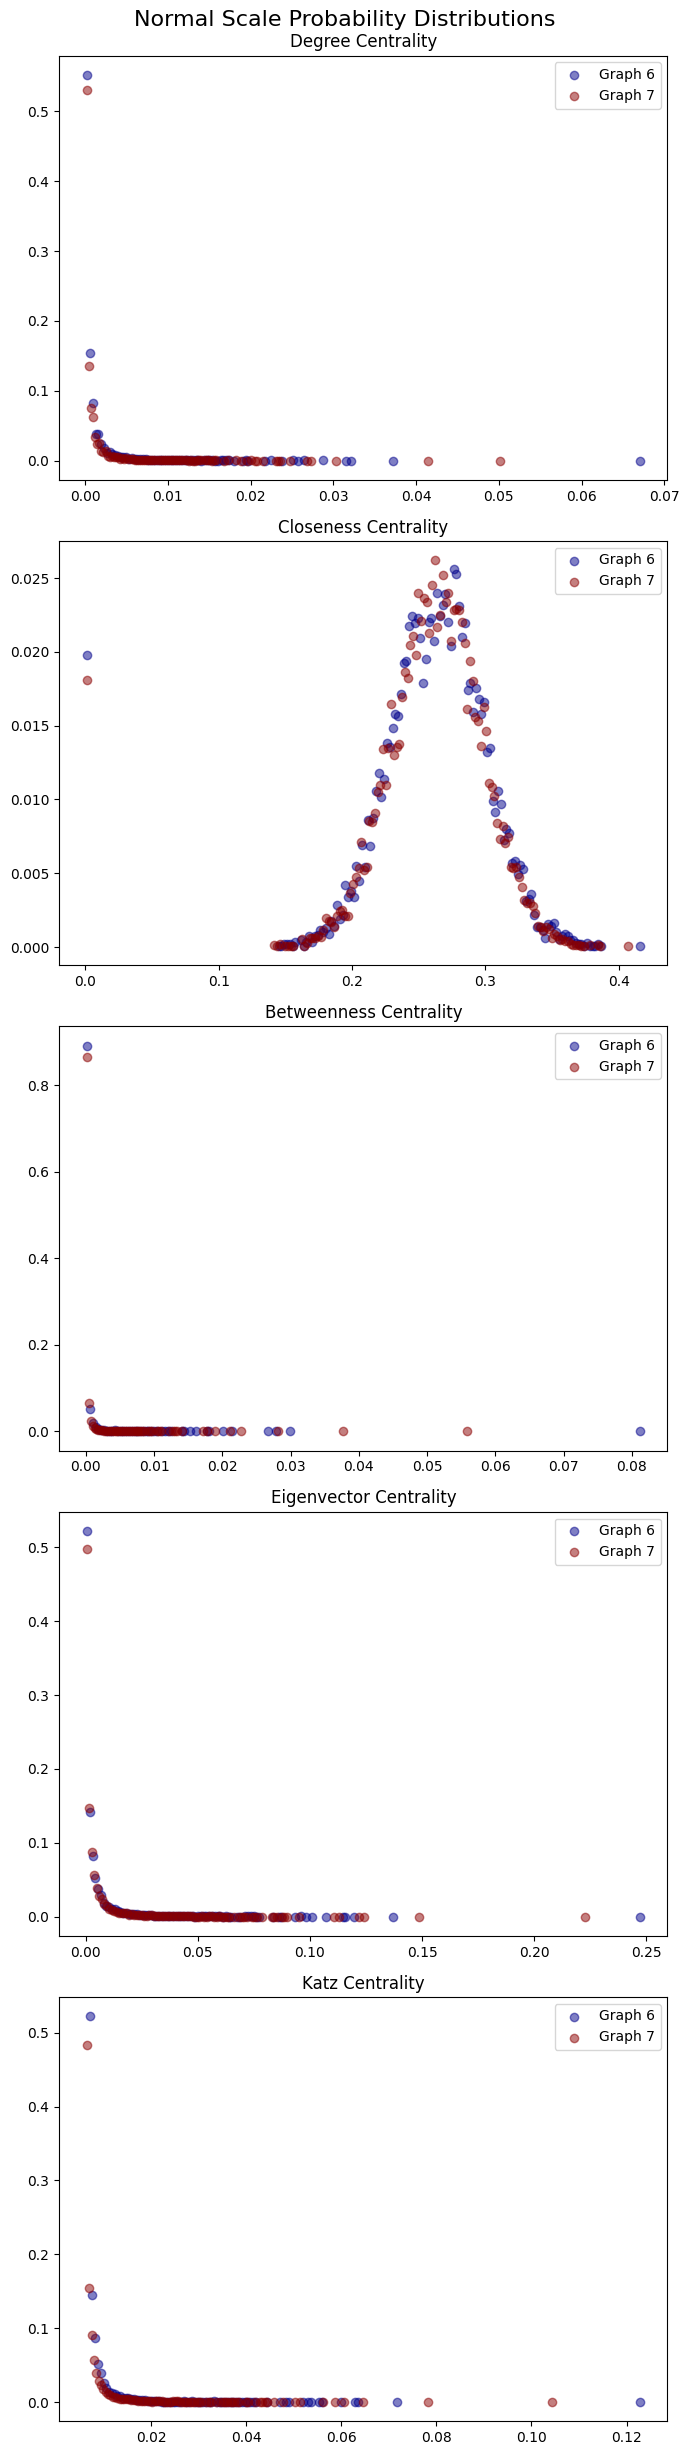

In [32]:
fig, axes = plt.subplots(5, 1, figsize=(7, 25))

for row, (measure1, measure2,title) in enumerate(zip(centrality_measures1, centrality_measures2,titles)):
    values1 = list(measure1.values())
    hist1, bins1 = np.histogram(values1, bins=200)
    bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
    bin_centers1 = bin_centers1[hist1 > 0]
    hist1 = hist1[hist1 > 0]
    hist1 = (hist1 / len(values1))

    values2 = list(measure2.values())
    hist2, bins2 = np.histogram(values2, bins=200)
    bin_centers2 = (bins2[:-1] + bins2[1:]) / 2
    bin_centers2 = bin_centers2[hist2 > 0]
    hist2 = hist2[hist2 > 0]
    hist2 = (hist2 / len(values2))

    axes[row].scatter(bin_centers1, hist1, marker='o', color='darkblue', alpha=0.5, label = 'Graph 6')
    axes[row].scatter(bin_centers2, hist2, marker='o', color='darkred', alpha=0.5, label = 'Graph 7')
    axes[row].set_title(title)      
    axes[row].legend(loc='upper right')
plt.suptitle("Normal Scale Probability Distributions\n", fontsize=16)  
plt.tight_layout()

It seems that all of the centralities, except closeness, follow something like a **Power-Law distribution**, where most of the nodes get low values and only some of them achieve to have a high degree. On the other hand, closeness centrality seems to follow **normal distribution**, that indicates that we have a well-connected network where the most nodes have similar values of closeness centrality. Let's now check the log-log scale centrality distributions in order to make sure about their form.

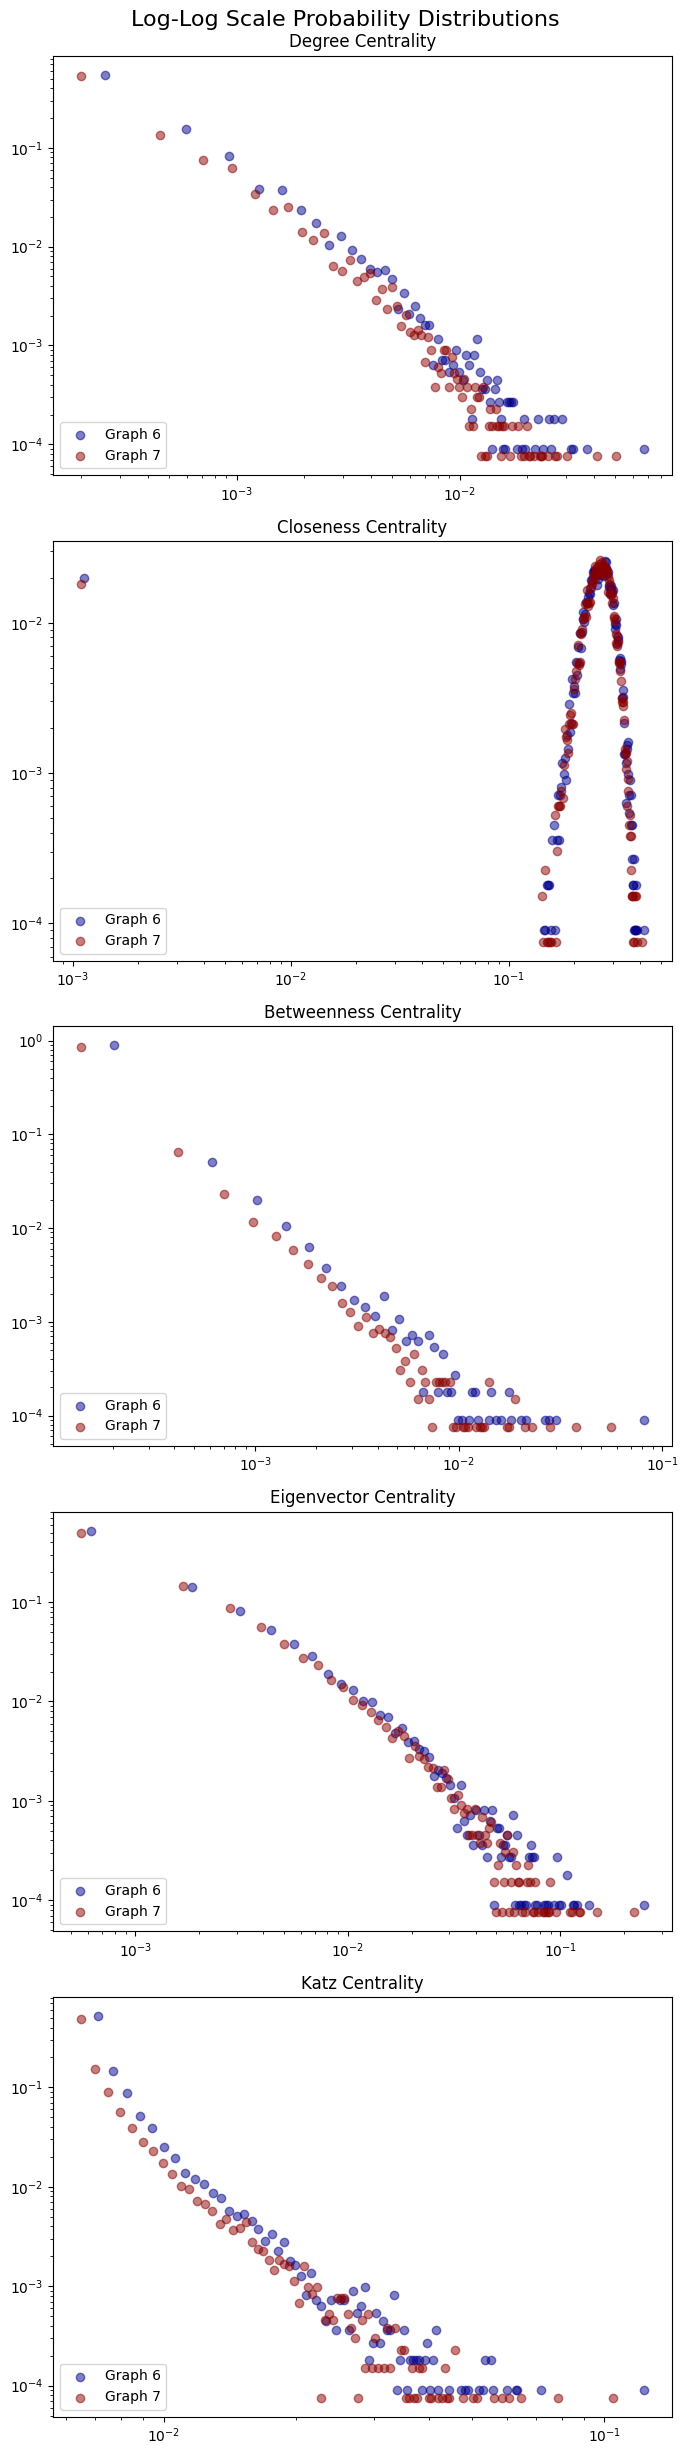

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(7, 25))

for row, (measure1, measure2,title) in enumerate(zip(centrality_measures1, centrality_measures2,titles)):
    values1 = list(measure1.values())
    hist1, bins1 = np.histogram(values1, bins=200)
    bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
    bin_centers1 = bin_centers1[hist1 > 0]
    hist1 = hist1[hist1 > 0]
    hist1 = (hist1 / len(values1))

    values2 = list(measure2.values())
    hist2, bins2 = np.histogram(values2, bins=200)
    bin_centers2 = (bins2[:-1] + bins2[1:]) / 2
    bin_centers2 = bin_centers2[hist2 > 0]
    hist2 = hist2[hist2 > 0]
    hist2 = (hist2 / len(values2))

    axes[row].scatter(bin_centers1, hist1, marker='o', color='darkblue', alpha=0.5, label = 'Graph 6')
    axes[row].scatter(bin_centers2, hist2, marker='o', color='darkred', alpha=0.5, label = 'Graph 7')
    axes[row].set_title(title)      
    axes[row].legend(loc='lower left')
    axes[row].set_yscale('log')
    axes[row].set_xscale('log')
plt.suptitle("Log-Log Scale Probability Distributions\n", fontsize=16)  
plt.tight_layout()

It seems that in log-log scale, the distributions are almost linear with a little curve and they have heteroscedasticity, which implies that **they follow a Truncated Power-Law Distribution where the tail is bounded with the max found centrality measure!**. Also the emergence of the truncated power law comes from **either aging or cost effect**. So we are in a network that new nodes, prefer to attach to the famous nodes (hubs). But how does every distribution changes through time?

By just watching the plots we cannot be sure about the changes of the distributions through time. So let's use **Kullback-Leibler (KL) divergence measure** in order to see how much does each distribution change through time.

![The Type of the KL Divergence is :](/home/andreas/Downloads/Graphs/Screenshot.png)

In [21]:
from scipy.special import kl_div

In [22]:
#Create a function that creates probability distributions

def create_probability_distribution(values):
    total = sum(values)
    probabilities = [v / total for v in values]
    return probabilities

In [23]:
#create a normalization function of the probabilities. We will add a tiny number to every probability to ensure we have all the p(x) and q(x) both > 0 and avoid dividing by 0.
def normalize_probabilities(probabilities, epsilon=1e-10):
    total = sum(probabilities) + len(probabilities) * epsilon
    normalized_probabilities = [(p + epsilon) / total for p in probabilities]
    return normalized_probabilities

Now compute the KLs for all the 5 centralities by using the following function:

**WE KNOW THAT THE DISTRIBUTIONS WILL HAVE DIFFERENT LENGTH AND KL -DIV WON'T WORK! So we always truncate (post truncation) the distribution with the more nodes!**

In [24]:
def get_kl_div(measures1,measures2):
        dist1 = create_probability_distribution(list(measures1.values()))
        dist2 = create_probability_distribution(list(measures2.values()))      
        min_length = min(len(dist1), len(dist2))
        dist1 = dist1[:min_length]
        dist2 = dist2[:min_length]
        dist1_norm = normalize_probabilities(dist1)
        dist2_norm = normalize_probabilities(dist2)
        return np.sum(kl_div(dist1_norm,dist2_norm))

We took the sum of kl_div because kl_div returns the distance of every x valued centality measure, and we wanted a value that represents the total difference of the 2 distributions. So we calcluate every KL-Div for the first 5 different Graphs, for every different centrality measurement.

In [38]:
kl_degree = get_kl_div(degree_centrality1,degree_centrality2)
kl_close = get_kl_div(closeness_centrality1,closeness_centrality2)
kl_bet = get_kl_div(betweenness_centrality1,betweenness_centrality2)
kl_eigen = get_kl_div(eigenvector_centrality1,eigenvector_centrality2)
kl_katz = get_kl_div(katz_centrality1,katz_centrality2)

And now let's check how each centrality measure differenciates between the 6th and the 7th month of the dataset.

In [39]:
print('The KL - Divergence for the Graphs 6 & 7 are: ')
print('-----------------------------------------------------')
print(f'Degree Centrality: {kl_degree}')
print(f'Closeness Centrality: {kl_close}')
print(f'Betweeness Centrality: {kl_bet}')
print(f'Eigenvector Centrality: {kl_eigen}')
print(f'Katz Centrality: {kl_katz}')

The KL - Divergence for the Graphs 6 & 7 are: 
-----------------------------------------------------
Degree Centrality: 1.4247068218102161
Closeness Centrality: 0.1470924261622017
Betweeness Centrality: 4.702912758129193
Eigenvector Centrality: 2.0902969195289405
Katz Centrality: 0.1020893323729962


It seems that as time passes, the centralities distributions that change the most are:

1. Betweenness

2. Degree Centrality

3. Eigenvector Centrality

**So we understand that we are in a dynamic network that changes over time. As the new nodes are entering the network, the structure gets affected and transformed.**

In [ ]:
degree_centrality50, closeness_centrality50, betweenness_centrality50, eigenvector_centrality50, katz_centrality50 = compute_centrality_measures(ith_subgraph(df,time_periods,50))
centrality_measures = [ degree_centrality50, closeness_centrality50, betweenness_centrality50, eigenvector_centrality50, katz_centrality50]
fig, axes = plt.subplots(5, 1, figsize=(7, 25))

for row, (measure1, measure2,title) in enumerate(zip(centrality_measures,titles)):
    values1 = list(measure1.values())
    hist1, bins1 = np.histogram(values1, bins=200)
    bin_centers1 = (bins1[:-1] + bins1[1:]) / 2
    bin_centers1 = bin_centers1[hist1 > 0]
    hist1 = hist1[hist1 > 0]
    hist1 = (hist1 / len(values1))

    axes[row].scatter(bin_centers1, hist1, marker='o', color='darkblue', alpha=0.5, label = 'Graph 50')
    axes[row].set_title(title)      
    axes[row].legend(loc='upper right')
plt.suptitle("Normal Scale Probability Distributions\n", fontsize=16)  
plt.tight_layout()

Let's continue by defining 2 more functions:

In [25]:
# Function to find the common set of nodes between two subgraphs
def common_nodes(subgraph_current, subgraph_next):
    return set(subgraph_current.nodes()).intersection(subgraph_next.nodes())

# Function to find the restricted set of edges within the common set of nodes
def restricted_edges(subgraph, common_nodes):
    return set([(u, v) for u, v in subgraph.edges() if (u in common_nodes and v in common_nodes)])


It is now time to check how the common nodes and common edges between 2 successive graphs lie through time, by graphically repressenting the number of these through time.

In [30]:
V_STAR = []
E_STAR_PREV = []
E_STAR_NEXT = []
graph_previous = ith_subgraph(df,time_periods,0)
for graph_next in subgraphs_generator(df, time_periods[1:]):
        v_star = common_nodes(graph_previous,graph_next)
        V_STAR.append(len(v_star))
        e_star_prev = restricted_edges(graph_previous, v_star)
        e_star_next = restricted_edges(graph_next, v_star)
        E_STAR_PREV.append(len(e_star_prev))
        E_STAR_NEXT.append(len(e_star_next))
        graph_previous = graph_next

        

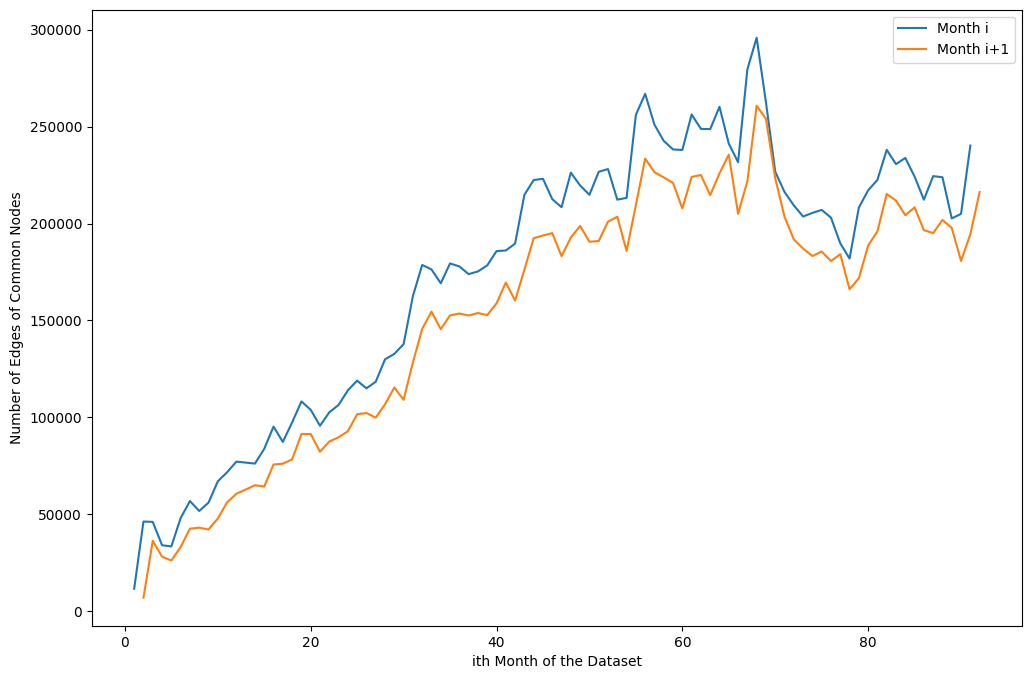

In [81]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(1,len(time_periods))], E_STAR_PREV, label='Month i')
plt.plot([i for i in range(2,len(time_periods)+1)], E_STAR_NEXT, label='Month i+1')
plt.xlabel('ith Month of the Dataset')
plt.ylabel('Number of Edges of Common Nodes')
plt.legend()
plt.show()

The plot indicates that for 2 nodes that are in the network for 2 succesive time periods, it is more possible that they have connected between the first period than the second, as the edges between these type of nodes seem to almost always be more in the 1st period than the 2nd. Let's plot also the difference of these plots.

In [32]:
E_STAR_DIFF = (np.array(E_STAR_NEXT) - np.array(E_STAR_PREV))

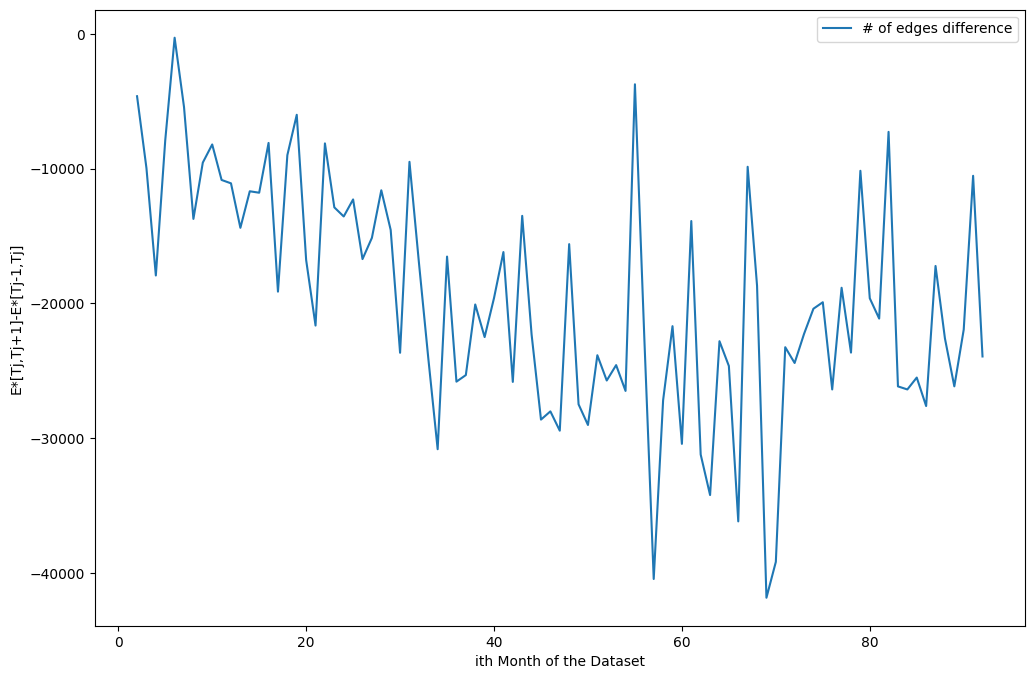

In [33]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(2,len(time_periods)+1)], E_STAR_DIFF, label = '# of edges difference')
plt.xlabel('ith Month of the Dataset')
plt.ylabel('E*[Tj,Tj+1]-E*[Tj-1,Tj]')
plt.legend()
plt.show()

Again, we can see that the difference between first and second day edges are almost always negative. This plots also indicates that as time passes, the difference between them tend to get bigger and bigger. **After about 70th Month it seems that the difference become more stable.** Let's check also how common nodes do through time.

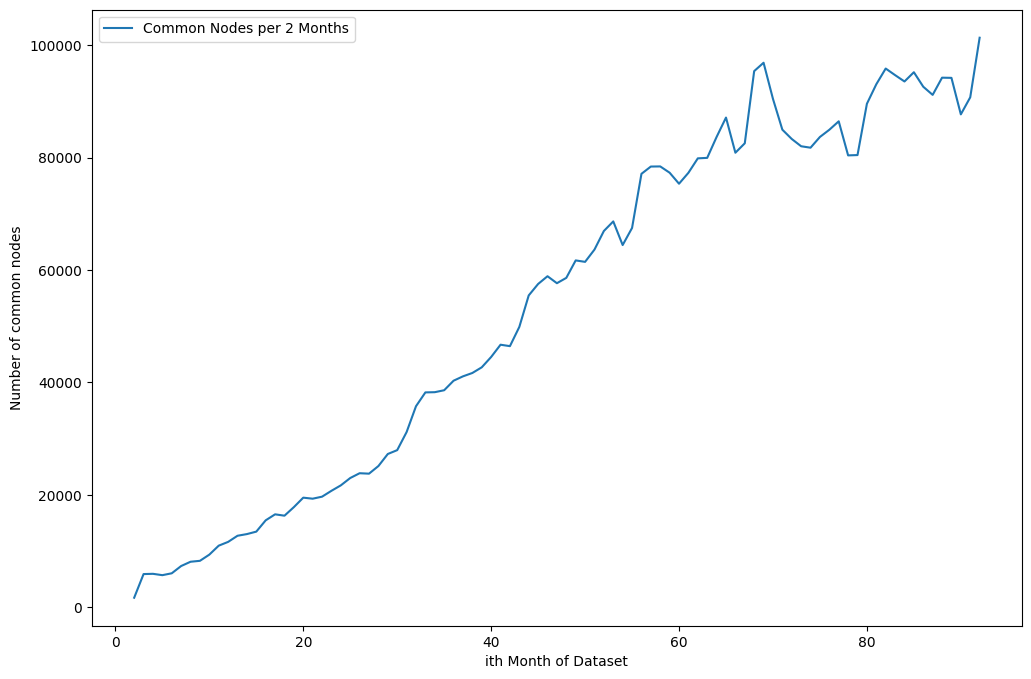

In [82]:
plt.figure(figsize=(12,8))
plt.plot([i for i in range(2,len(time_periods)+1)], V_STAR, label='Common Nodes per 2 Months')
plt.xlabel('ith Month of Dataset')
plt.ylabel('Number of common nodes')
plt.legend()
plt.show()

tj = [T[0] + j*dt for j in range(N+1)]

In this plot we can see that as time passes, the common nodes that are in the intersection of G[Tj-1,Tj] and G[Tj,Tj+1] tend to becoming more and more numerous. **After about 70th Month the nodes aren't getting more numerous with the same speed as before**

It is now time to **create functions that calculates the distances as required by Part2, exercise 2**

In [26]:
def graph_distance(subgraph, u, v):
    if nx.has_path(subgraph, u, v):
        shortest_path = nx.shortest_path_length(subgraph, source=u, target=v)
    else:
        shortest_path =  math.inf # 
    return 1 / shortest_path

def common_neighbors(subgraph, u, v):
    neighbors_u = set(subgraph[u])
    neighbors_v = set(subgraph[v])
    return len(neighbors_u.intersection(neighbors_v))

def jaccard_coefficient(subgraph, u, v):
    neighbors_u = set(subgraph[u])
    neighbors_v = set(subgraph[v])
    union_size = len(neighbors_u.union(neighbors_v))
    if union_size == 0:
        return 0
    return len(neighbors_u.intersection(neighbors_v)) / union_size

def adamic_adar(subgraph, u, v):
    common_neighbors = set(subgraph[u]).intersection(set(subgraph[v]))
    if len(common_neighbors) == 0:
        return 0
    return sum(1 / math.log(len(subgraph[neighbor]), 2) if math.log(len(subgraph[neighbor]), 2) != 0 else 0 for neighbor in common_neighbors)

def preferential_attachment(subgraph, u, v):
    degree_u = subgraph.degree(u)
    degree_v = subgraph.degree(v)
    return degree_u * degree_v

Create a generator that iritates through the nodes of V*, an it **returns for every possible edge, the edge, the metrics and the label as calculated from which e_star the user will give it.**

In [27]:
import random

In [ ]:
#Version1
def get_metrics_gen(graph_star,e_star):
    e_non_ex = set()
    for (u,v) in list(e_star):
        dist = graph_distance(graph_star, u, v)
        neighbours = common_neighbors(graph_star, u, v)
        jaccard = jaccard_coefficient(graph_star, u, v)
        adar = adamic_adar(graph_star, u, v)
        pref = preferential_attachment(graph_star, u, v)
        label = 1
        yield (u,v),dist,neighbours,jaccard,adar,pref,label

        u_degree = graph_star.degree(u)
        v_degree = graph_star.degree(v)
        #Keep as source the less popular node
        if u_degree <= v_degree:
            source = u
            target = v
        else:
            source = v
            target = u

        source_neighbors = set(graph_star.neighbors(source))
        target_neighbors = set(graph_star.neighbors(target))
        probable_future_connection_with_source = target_neighbors - target_neighbors.intersection(source_neighbors)

        not_connected_with_source = [node for node in probable_future_connection_with_source if not graph_star.has_edge(node, source)]
        #Try 5 times to connect with a target neighbor
        #If you tried 5 times, give me a random v_new
        pos = 0
        while True:
            if len(not_connected_with_source) > 0:
                v_new = random.choice(not_connected_with_source)
                if (source,v_new) not in e_star and (v_new,source) not in e_star and (source,v_new) not in e_non_ex and (v_new,source) not in e_non_ex and (source != v_new ):
                    #print('not Random')
                    break
            if pos >= 5 or len(not_connected_with_source) == 0:
                v_new = random.choice(list(graph_star.nodes))
                if (source,v_new) not in e_star and (v_new,source) not in e_star and (source,v_new) not in e_non_ex and (v_new,source) not in e_non_ex and (source != v_new ):
                    #print('random')
                    break
            pos += 1

        e_non_ex.add((source,v_new))
        dist = graph_distance(graph_star, source, v_new)
        neighbours = common_neighbors(graph_star, source, v_new)
        jaccard = jaccard_coefficient(graph_star, source, v_new)
        adar = adamic_adar(graph_star, source, v_new)
        pref = preferential_attachment(graph_star, source, v_new)
        label = 0
        yield  (source,v_new) , dist, neighbours, jaccard, adar, pref, label

As we have defined all the required functions and generators, it is now time to create the training and test dataset. We will iritate through all the subgraphs by everytime keeping on memory only 2 them . As we iritating, we will append on the training dataset the data that are calculated from Gtrain graph and we will append on the testing dataset the data that are calculated from Gtest graph.

In [ ]:
possible_edges_train = []
distance_train = []
neighbors_train = []
jaccard_train = []
adar_train = []
pref_train = []
label_train = []

possible_edges_test = []
distance_test = []
neighbors_test = []
jaccard_test = []
adar_test = []
pref_test = []
label_test = []

graph_previous = ith_subgraph(df,time_periods,0)
for graph_next in subgraphs_generator(df, time_periods[1:]):

        e_star_prev = list(restricted_edges(graph_previous, common_nodes(graph_previous,graph_next)))
        G_train = nx.Graph()
        G_train.add_edges_from(e_star_prev)

        for possible_edge, sgd, scn, sjc, sa, spa,label  in get_metrics_gen(G_train,e_star_prev):
                possible_edges_train.append(possible_edge)
                distance_train.append(sgd)
                neighbors_train.append(scn)
                jaccard_train.append(sjc)
                adar_train.append(sa)
                pref_train.append(spa)
                label_train.append(label)

        e_star_next = list(restricted_edges(graph_next, common_nodes(graph_previous,graph_next)))
        G_test = nx.Graph()
        G_test.add_edges_from(e_star_next)

        for possible_edge, sgd, scn, sjc, sa, spa,label  in get_metrics_gen(G_test,e_star_next):
                possible_edges_test.append(possible_edge)
                distance_test.append(sgd)
                neighbors_test.append(scn)
                jaccard_test.append(sjc)
                adar_test.append(sa)
                pref_test.append(spa)
                label_test.append(label)
                
        graph_previous = graph_next

                        

Export each data to a training and a testing csv, in order to continue to a new Jupyter File.

In [ ]:
csv_file_path = "monthly1_train.csv"
chunksize = 10000
import csv
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['possible_edges', 'distance', 'neighbors', 'jaccard', 'adar', 'pref','label'])  # Write header
    
    chunk = []
    for row in zip(possible_edges_train, distance_train, neighbors_train, jaccard_train, adar_train, pref_train,label_train):
        chunk.append(row)
        
        if len(chunk) == chunksize:
            writer.writerows(chunk)
            chunk = []
    
    if chunk:
        writer.writerows(chunk) 

In [ ]:
csv_file_path = "monthly1_test.csv"
chunksize = 10000
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['possible_edges', 'distance', 'neighbors', 'jaccard', 'adar', 'pref','label'])  # Write header
    
    chunk = []
    for row in zip(possible_edges_test, distance_test, neighbors_test, jaccard_test, adar_test, pref_test,label_test):
        chunk.append(row)
        
        if len(chunk) == chunksize:
            writer.writerows(chunk)
            chunk = []
    
    if chunk:
        writer.writerows(chunk) 